# CIFAR-10 이미지 생성하기

In [1]:
# 모듈 import
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
%matplotlib inline

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 6GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0], 
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

In [2]:
# 데이터셋 구성
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [3]:
# pixel 값 확인
print("max pixel:", train_x.max()) # 255
print("min pixel:", train_x.min()) # 0

max pixel: 255
min pixel: 0


In [4]:
# 이미지를 -1, 1로 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel:", train_x.max())
print("min pixel:", train_x.min())

max pixel: 1.0
min pixel: -1.0


In [5]:
# dataset shape
train_x.shape

(50000, 32, 32, 3)

In [6]:
train_x = train_x.reshape(train_x.shape[0], 32, 32, 3).astype('float32')
train_x.shape

(50000, 32, 32, 3)

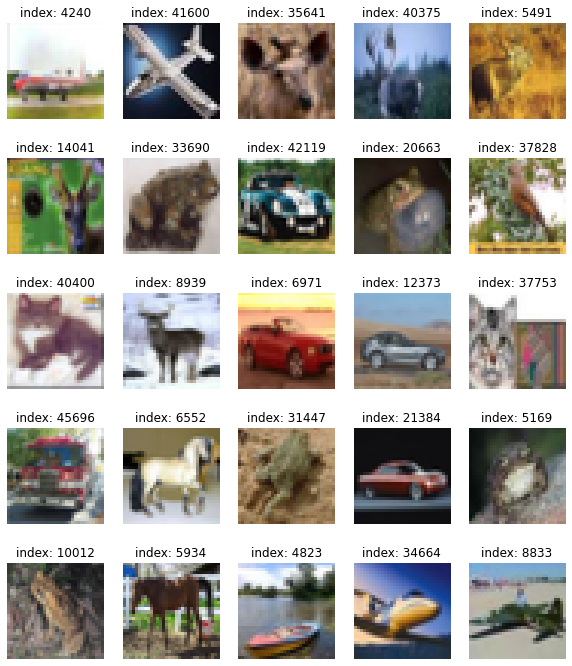

In [7]:
# 이미지 확인
plt.figure(figsize=(10, 12))

for i in range(25):
    plt.subplot(5, 5, i+1)
    random_index = np.random.randint(1, 50000)
    plt.imshow((train_x[random_index].reshape(32, 32, 3) + 1) / 2)
    plt.title(f'index: {random_index}')
    plt.axis('off')
plt.show()

In [8]:
# 미니배치 구성
BUFFER_SIZE = 50000
BATCH_SIZE = 256

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [9]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16384)             1638400   
_________________________________________________________________
batch_normalization (BatchNo (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 16384)             0         
_________________________________________________________________
reshape (Reshape)            (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 8, 8, 128)         0

In [11]:
# 노이즈 벡터 생성
noise = tf.random.normal([1, 100])

In [12]:
# 이미지 생성
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

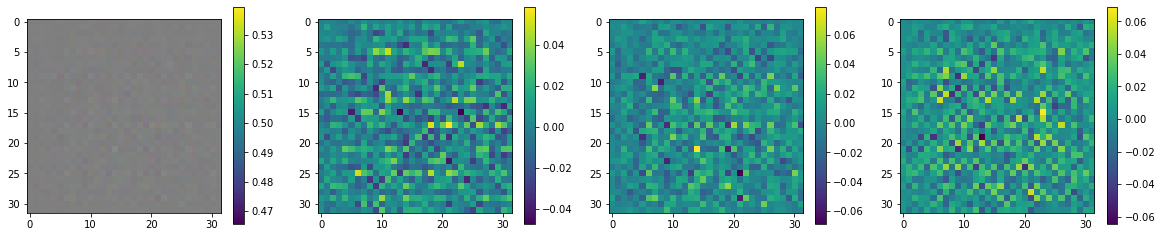

In [13]:
# 이미지 시각화
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.imshow((generated_image[0, :, :, ] + 1) / 2)
plt.colorbar()
for i in range (3):
    plt.subplot(1, 4, i+2)
    plt.imshow(generated_image[0, :, :, i])
    plt.colorbar()
plt.show()

In [14]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)             

In [16]:
# 이미지 확인
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.0013197]], dtype=float32)>

In [17]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
# generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [19]:
# discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
# discriminator accracy
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
# 샘플 생성
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

In [23]:
# train step 함수 정의
@tf.function
def train_step(images):  #(1) 입력데이터
    noise = tf.random.normal([BATCH_SIZE, noise_dim])  #(2) 생성자 입력 노이즈

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:  #(3) tf.GradientTape() 오픈
        generated_images = generator(noise, training=True)  #(4) generated_images 생성

        #(5) discriminator 판별
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #(6) loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

        #(7) accuracy 계산
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output) 
    
    #(8) gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #(9) 모델 학습
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_accuracy, fake_accuracy  #(10) 리턴값

In [24]:
# 일정 학습 당 샘플 생성 함수
def generate_and_save_images(model, epoch, it, sample_seeds):

    predictions = model(sample_seeds, training=False)
    predictions = (predictions + 1) / 2.0
    fig = plt.figure(figsize=(4, 4))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, :])
        plt.axis('off')

    plt.savefig('./generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                .format(epoch, it))

    plt.show()

In [25]:
# 학습 결과 시각화
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6    # matlab 차트의 기본 크기를 15,6으로 지정해 줍니다.

def draw_train_history(history, epoch):
    # summarize history for loss  
    plt.subplot(211)  
    plt.plot(history['gen_loss'])  
    plt.plot(history['disc_loss'])  
    plt.title('model loss')  
    plt.ylabel('loss')  
    plt.xlabel('batch iters')  
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')  

    # summarize history for accuracy  
    plt.subplot(212)  
    plt.plot(history['fake_accuracy'])  
    plt.plot(history['real_accuracy'])  
    plt.title('discriminator accuracy')  
    plt.ylabel('accuracy')  
    plt.xlabel('batch iters')  
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')  
    
    # training_history 디렉토리에 epoch별로 그래프를 이미지 파일로 저장합니다.
    plt.savefig('./training_history/train_history_{:04d}.png'
                .format(epoch))
    plt.show()

In [26]:
# checkpoint 설정
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [27]:
# train 함수 정의
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
# 학습 횟수 및 저장간격 설정
save_every = 20
EPOCHS = 100

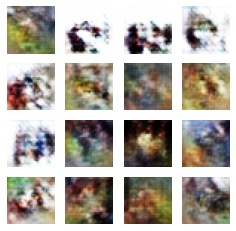

Time for training : 1010 sec


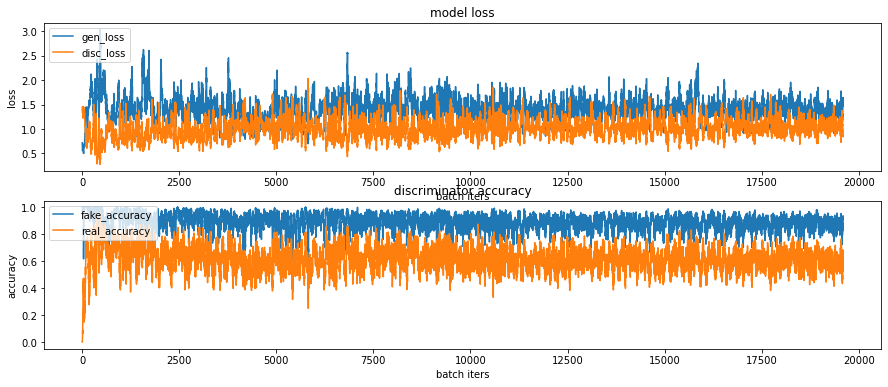

Wall time: 16min 51s


In [31]:
%%time
train(train_dataset, EPOCHS, save_every)

In [32]:
anim_file = './cifar10_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./generated_samples/sample*.png')
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
print("finish")

finish


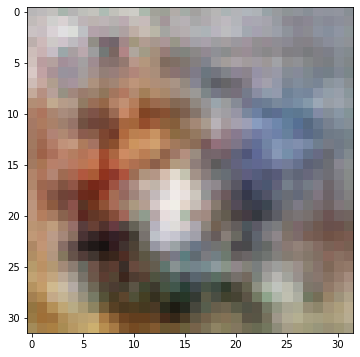

In [33]:
checkpoint_dir = './training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

fig = plt.figure(figsize=(3, 2))
plt.imshow(np_generated[0])
plt.show()  # 정상적으로 모델이 로드되었다면 랜덤 이미지가 아니라 CIFAR-10 이미지가 그려질 것입니다.

![baseline](./gif/cifar10_dcgan_baseline.gif)

노드에서 주어진 가장 기본적인 모델로 학습을 진행했을 때, Generator모델의 학습이 덜 되어 이미지를 알아보기 어려웠다. 따라서 2000epoch 까지 추가적으로 학습을 더 진행시켜 보았으나 일정 epoch 이상에서는 학습이 더이상 진행되지 않았다.

![training_histroy](./training_history/baseline_train_history_2000.png)
![generated_sample](./generated_samples/baseline_sample_epoch_2000.png)
![baseline](./gif/cifar10_dcgan_baseline_2000.gif)

## GAN 훈련 과정 개선하기

추가적으로 GAN의 훈련 과정을 개선하기 위해 다음 사이트들을 참고하여 여러 가지 방법을 시도해 보았다.   


https://machinelearningmastery.com/how-to-train-stable-generative-adversarial-networks/   


https://github.com/soumith/ganhacks

### (1) Optimizer의 learning rate 증가
- Adam Optimizer의 learning rate를 기존의 0.0001에서 0.0003으로 증가시켜 보았다.
- 사용한 모델은 다음과 같다.

In [29]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [30]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_3 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 16384)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 8, 8, 128)        

In [31]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [32]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)             

In [33]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.5)

# 학습 횟수 및 저장간격 설정
save_every = 50
EPOCHS = 200

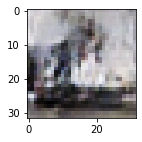

In [36]:
checkpoint_dir = '/home/ssac10/aiffel/dcgan_newimage/cifar10_rev9/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator

# 로드한 모델이 정상적으로 이미지를 생성하는지 확인해 봅니다. 
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)

fig = plt.figure(figsize=(3, 2))
plt.imshow(np_generated[0])
plt.show()

![training_histroy](./training_history/rev1_train_history.png)
![generated_sample](./generated_samples/rev1_sample.png)
![gif](./gif/cifar10_dcgan_rev1.gif)

- 200epoch을 돌리긴 했지만 실제로 100epoch에서의 이미지와 비교해봤을 땐 충분히 Generator의 학습 속도가 빠른 것을 확인할 수 있었다.

### (2) Generator Model에 Dropout Layer 추가
- Generator Model에 Dropout Layer 추가하면 GAN 학습을 향상시킬 수 있다고 하여 기존 모델에 Dropout Layer만 추가해보았다.
- 사용한 모델은 다음과 같다.

In [51]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(8*8*256, use_bias=False, input_shape=(100, )))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Second: Reshape layer
    model.add(layers.Reshape((8, 8, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.5))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [52]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16384)             1638400   
_________________________________________________________________
batch_normalization_9 (Batch (None, 16384)             65536     
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16384)             0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 16384)             0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 8, 8, 128)         819200    
_________________________________________________________________
batch_normalization_10 (Batc (None, 8, 8, 128)        

In [53]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [54]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 8192)             

In [55]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.5)

# 학습 횟수 및 저장간격 설정
save_every = 50
EPOCHS = 400

![training_histroy](./training_history/rev2_train_history.png)
![generated_sample](./generated_samples/rev2_sample.png)
![gif](./gif/cifar10_dcgan_rev2.gif)

- 400epoch을 돌리긴 했지만 100epoch정도 부터 학습이 진행되지 않는 것을 확인할 수 있었다.
- Dropout을 적용했더니 생성된 이미지가 전반적으로 흐려보이는 것 같이 느껴졌다.
- 어느 정도 개체를 판단할 수 있는 이미지가 있었다.

### (3) Generator, Discriminator의 Layer 추가
- Generator, Discriminator의 Layer를 더 추가시켜 더 깊은 Network를 만들어보았다.
- 사용한 모델은 다음과 같다.

In [57]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*256, use_bias=False, input_shape=(100, )))
    model.add(layers.Reshape((4, 4, 256)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(256, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(3, 3), padding='same', activation='tanh'))

    return model

In [58]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 4096)              409600    
_________________________________________________________________
reshape_4 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 4, 4, 256)         1024      
_________________________________________________________________
leaky_re_lu_20 (LeakyReLU)   (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_12 (Conv2DT (None, 8, 8, 256)         1048832   
_________________________________________________________________
batch_normalization_13 (Batc (None, 8, 8, 256)         1024      
_________________________________________________________________
leaky_re_lu_21 (LeakyReLU)   (None, 8, 8, 256)        

In [59]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [60]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 16, 16, 64)        1792      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
batch_normalization_16 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 4, 4, 256)         295168    
_________________________________________________________________
batch_normalization_17 (Batc (None, 4, 4, 256)        

In [61]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5)

# 학습 횟수 및 저장간격 설정
save_every = 50
EPOCHS = 400

![training_histroy](./training_history/rev3_train_history.png)
![generated_sample](./generated_samples/rev3_sample.png)
![gif](./gif/cifar10_dcgan_rev3.gif)

- 400epoch을 돌리긴 했지만 여전히 어느 정도를 넘어서는 학습이 진행된다기 보단 특징들이 사라지고 생기는 것을 반복하는 것 처럼 보였다.
- Layer를 추가하였더니 확실히 개체를 좀 더 잘 알아볼 수 있는 이미지들이 늘어났다.

### (4) Generator, Discriminator의 Layer 추가 후 Parameter 증가 및 활성화 함수 변경
- Generator, Discriminator의 Layer를 더 추가시켜 더 깊은 Network를 만들고, channel을 늘려서 Parameter를 증가시켜 보았다.
- Generator Model에 ReLU를 사용하면 Network를 향상시킬 수 있다고 하여 한번 바꿔보았다.
- 논문을 참고하여 다음과 같이 Parameter를 증가시켰다.

In [62]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100, )))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())


    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), padding='same', activation='tanh'))

    return model

In [63]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
reshape_5 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization_19 (Batc (None, 4, 4, 1024)        4096      
_________________________________________________________________
re_lu (ReLU)                 (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_16 (Conv2DT (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_20 (Batc (None, 8, 8, 512)         2048      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 8, 8, 512)       

In [64]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [65]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
batch_normalization_23 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_28 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_24 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_29 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 512)       

In [66]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0004, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.5)

# 학습 횟수 및 저장간격 설정
save_every = 20
EPOCHS = 200

![training_histroy](./training_history/rev5_train_history.png)
![generated_sample](./generated_samples/rev5_sample.png)
![gif](./gif/cifar10_dcgan_rev5.gif)

- 앞서 모델을 돌려본 결과, learning rate를 조절하면 200epoch 정도에서도 충분히 학습이 완료되는 것으로 보였기 때문에 200epoch만 돌려보았다.
- Parameter 증가에 따라 1epoch 당 걸리는 시간이 엄청나게 늘어났다. 거의 1epoch당 70s 정도?
- 이미지의 품질이 눈에 띄게 좋아졌다. 이전과 같이 이미지에서 특정 색상값이 튀는 문제도 확실히 감소하였다.

### (5) 4번 + Generator Model에 Dropout 추가
- 4번 모델에 Generator Model에 Dropout 을 추가로 적용시켜 보았다.
- 사용된 모델은 다음과 같다.

In [67]:
# 생성자 모델 정의
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(4*4*1024, use_bias=False, input_shape=(100, )))
    model.add(layers.Reshape((4, 4, 1024)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2DTranspose(512, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2DTranspose(256, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())
    model.add(layers.Dropout(0.5))


    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(3, kernel_size=(5, 5), padding='same', activation='tanh'))

    return model

In [68]:
# 생성자 모델 요약
generator = make_generator_model()

generator.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 16384)             1638400   
_________________________________________________________________
reshape_6 (Reshape)          (None, 4, 4, 1024)        0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 4, 4, 1024)        4096      
_________________________________________________________________
re_lu_4 (ReLU)               (None, 4, 4, 1024)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose_20 (Conv2DT (None, 8, 8, 512)         13107712  
_________________________________________________________________
batch_normalization_28 (Batc (None, 8, 8, 512)       

In [69]:
# 판별자 모델 정의
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(1, 1), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    
    model.add(layers.Conv2D(1024, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [70]:
# 모델 요약
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 32, 32, 128)       9728      
_________________________________________________________________
batch_normalization_31 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_32 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
batch_normalization_32 (Batc (None, 16, 16, 256)       1024      
_________________________________________________________________
leaky_re_lu_33 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 8, 8, 512)       

In [72]:
# Optimizer
generator_optimizer = tf.keras.optimizers.Adam(lr=0.0004, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(lr=0.0003, beta_1=0.5)

# 학습 횟수 및 저장간격 설정
save_every = 50
EPOCHS = 200

![training_histroy](./training_history/rev6_train_history.png)
![generated_sample](./generated_samples/rev6_sample.png)
![gif](./gif/cifar10_dcgan_rev6.gif)

- 4번 모델에 Dropout을 추가했더니 신기한 현상이 발생했다. 이미지의 품질은 여전하지만 녹색이 두드러지는 현상이 나타났다. 이것에 대한 원인은 잘 모르겠다.

## 회고록
- GAN 모델이 지금까지 학습했던 모델 중 가장 복잡하다고 느껴졌다. 아무래도 생성자와 판별자를 구분해서 모델을 설계해야해서 그런 것 같다.
- 실제로 학습이 되어가는 과정을 보니 신기하기도 하다. 머리로는 알고 있는 개념이었지만 실제로 모델은 만들어서 학습 과정을 보는 것은 처음이었기 때문인 것 같다.
- 적은 epoch으로는 생각보다 잘 생성하지 못하는 것 같다.
- 노드에 있는 모델을 그대로 써서 2000epoch을 돌려봤지만 일정 epoch 이상에서는 학습이 종료되어 더이상 생성되는 사진의 형태가 큰 변화가 없는 시점이 있었다.
- 원본 이미지의 해상도가 낮은 탓인지 생성된 이미지를 생각보다 알아보기 어려워서 인식률을 향상시킬 수 있는 방법들을 찾아보았다.
- parameter도 바꿔보고, 활성화 함수도 바꿔보고, Dropout을 추가해보기도 하고 여러 방법을 시도해보았더니 100~200 정도의 epoch으로도 어느 정도 형체를 알아볼 수 있는 정도로 학습이 되었다.
- 정말 학습이 잘 되면 원본 이미지 처럼 나올 줄 알았는데 아무리 시도해도 생성된 이미지 전부가 정상적으로 알아볼 수 있게 하기는 어려웠다. 생각해보니 정확도가 100%가 아니기 때문에 전부 다 알아볼 수 없는 것은 당연한 것이었다.
- 거의 3일 내내 딥러닝 모델을 쉬지 않고 돌렸던 것 같다. 노트북에 기재하지 않은 Data들도 많이 있지만 이걸 다 넣기엔 조건들이 너무 제각각이어서 어느 정도 유의미하다고 생각되는 결과만 넣었다.
- 다음번에 딥러닝 모델 학습을 진행할 땐 조금 더 체계적인 실험 계획을 가지고 모델을 학습시켜봐야겠다. 한 번에 하나의 요인만을 수정해야 하는데 그렇지 못해서 특정 요인이 미치는 영향에 대해 정확하게 추정하기 어려웠다.